In [1]:
pip install tensorflow opencv-python matplotlib scikit-learn numpy pandas

In [4]:
!unzip -q fer2013.zip

In [5]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

# Define constants
IMG_SIZE = (48, 48)
BATCH_SIZE = 64
# DATA_DIR = "/content/fer2013.zip" # e.g., "../fer2013"

# Load training and validation data
train_dataset = image_dataset_from_directory(
    f"/content/train",
    label_mode='categorical', # One-hot encodes labels
    color_mode='grayscale',   # FER2013 images are grayscale
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    validation_split=0.2,     # Use 20% of training data for validation
    subset="training",
    seed=42
)

validation_dataset = image_dataset_from_directory(
    f"/content/train",
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=42
)

# Load test data
test_dataset = image_dataset_from_directory(
    f"/content/test",
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False # No need to shuffle the test set
)

# Check class names
class_names = train_dataset.class_names
print("Emotion classes:", class_names)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.
Emotion classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [6]:
from tensorflow.keras import layers, models

# Create a preprocessing layer for rescaling
rescale = layers.Rescaling(scale=1./255)

# Create data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# Apply these layers to the datasets
# Note: We only augment the training data
train_dataset = train_dataset.map(lambda x, y: (rescale(x), y))
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

validation_dataset = validation_dataset.map(lambda x, y: (rescale(x), y))
test_dataset = test_dataset.map(lambda x, y: (rescale(x), y))

# Use buffered prefetching to avoid I/O blocking
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
def build_model(input_shape=(48, 48, 1), num_classes=7):
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25)) # Dropout to prevent overfitting

    # Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Classifier Head
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5)) # Higher dropout for dense layers
    model.add(layers.Dense(num_classes, activation='softmax')) # Output layer

    return model

# Build the model
model = build_model()
model.summary() # Print the model architecture

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,653,671 (10.12 MB)

 Trainable params: 2,651,751 (10.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [8]:
# Define Learning Rate Reduction callback to refine training
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-7
)

# Define Early Stopping callback to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
# Define the number of epochs
epochs = 100

# Train the model
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset,
    callbacks=[lr_callback, early_stopping] # Use the callbacks
)

# Save the trained model for later use
model.save('fer_cnn_model_from_scratch.keras')

Epoch 1/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 34s 57ms/step - accuracy: 0.2204 - loss: 2.4476 - val_accuracy: 0.1986 - val_loss: 2.1236 - learning_rate: 0.0010
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.3241 - loss: 1.7704 - val_accuracy: 0.4052 - val_loss: 1.5623 - learning_rate: 0.0010
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.4036 - loss: 1.5605 - val_accuracy: 0.4673 - val_loss: 1.3834 - learning_rate: 0.0010
Epoch 4/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.4435 - loss: 1.4472 - val_accuracy: 0.5037 - val_loss: 1.2898 - learning_rate: 0.0010
Epoch 5/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.4667 - loss: 1.3912 - val_accuracy: 0.5037 - val_loss: 1.3103 - learning_rate: 0.0010
Epoch 6/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.4839 - loss: 1.3397 - val_accuracy: 0.4874 - val_loss: 1.3195 - learning_rate: 0.0010
Epoch 7/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.50

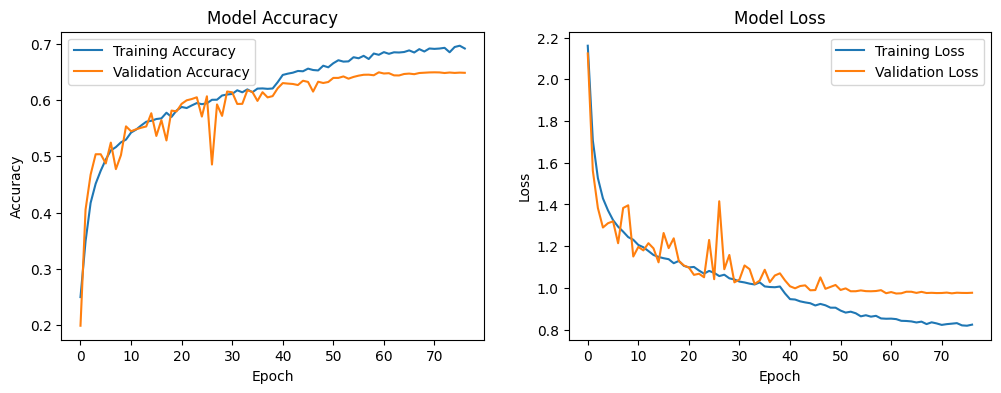

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6078 - loss: 1.0571

Test Accuracy: 0.6481
Test Loss: 0.9634

Classification Report:
              precision    recall  f1-score   support

       angry       0.55      0.59      0.57       958
     disgust       0.72      0.40      0.51       111
        fear       0.55      0.37      0.44      1024
       happy       0.86      0.87      0.86      1774
     neutral       0.54      0.69      0.61      1233
         sad       0.52      0.52      0.52      1247
    surprise       0.77      0.76      0.76       831

    accuracy                           0.65      7178
   macro avg       0.65      0.60      0.61      7178
weighted avg       0.65      0.65      0.64      7178



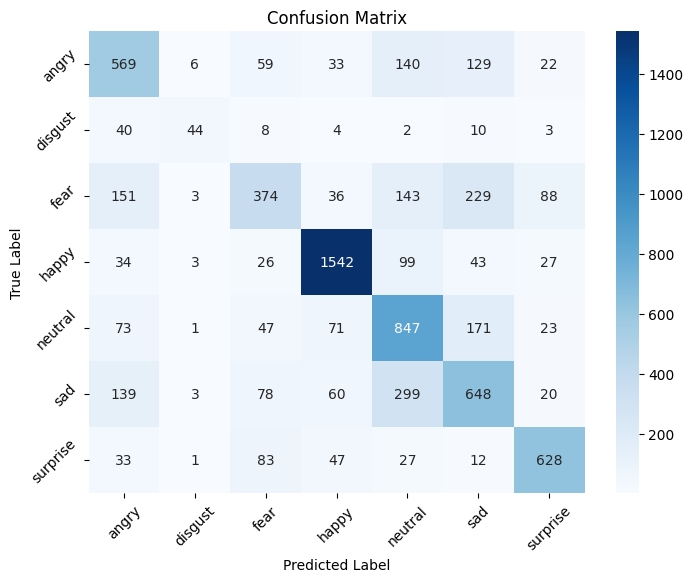

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1. Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2. Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# 3. Detailed Report and Confusion Matrix
# Get all true labels and predictions
y_true = []
y_pred = []

for images, labels in test_dataset:
    y_true.extend(np.argmax(labels.numpy(), axis=1)) # Convert one-hot to integers
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [20]:
import cv2
import numpy as np

def predict_emotion(image_path, model, class_names):
    """
    Predicts the emotion from a single image file.
    """
    # 1. Read and preprocess the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # Read as grayscale
    if img is None:
        print("Error: Could not load image.")
        return None

    # 2. Resize to match model input
    img = cv2.resize(img, (48, 48))
    # 3. Rescale pixels (same as training)
    img = img / 255.0
    # 4. Add batch and channel dimensions: (1, 48, 48, 1)
    img = np.expand_dims(img, axis=[0, -1])

    # 5. Predict
    predictions = model.predict(img, verbose=0)[0]
    predicted_class_idx = np.argmax(predictions)
    predicted_emotion = class_names[predicted_class_idx]
    confidence = predictions[predicted_class_idx]

    # 6. Display result
    print(f"Predicted Emotion: {predicted_emotion} (Confidence: {confidence:.2f})")
    # Optional: Print all probabilities
    for i, emotion in enumerate(class_names):
        print(f"  {emotion}: {predictions[i]:.4f}")

    return predicted_emotion, confidence

# Use the function
prediction, confidence = predict_emotion("/content/Screenshot 2025-09-03 105900.png", model, class_names)

Predicted Emotion: surprise (Confidence: 0.85)
  angry: 0.0334
  disgust: 0.0003
  fear: 0.1151
  happy: 0.0002
  neutral: 0.0005
  sad: 0.0010
  surprise: 0.8495


Testing prediction on a new image...
Original Image (BGR format):


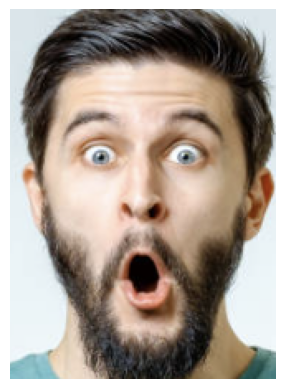

Grayscale Image:


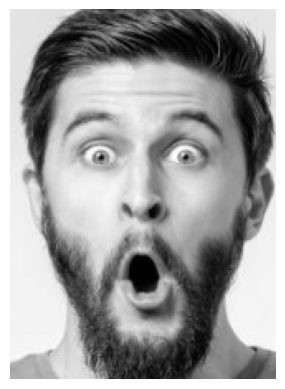

Resized Image (48x48):


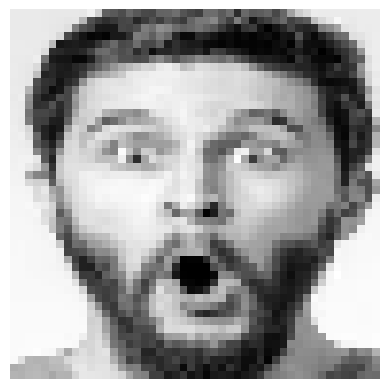

Pixel value range after normalization: [0.004, 0.973]
Final input shape for model: (1, 48, 48, 1)

--- PREDICTION RESULTS ---
Predicted Emotion: surprise (Confidence: 83.47%)

All probabilities:
  angry     : 0.0314
  disgust   : 0.0003
  fear      : 0.1318
  happy     : 0.0002
  neutral   : 0.0005
  sad       : 0.0010
  surprise  : 0.8347

Final Output with Prediction:


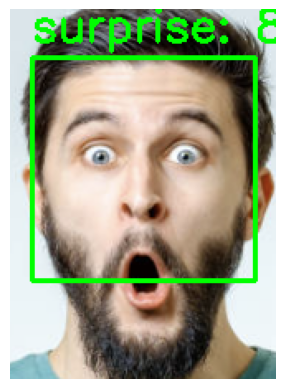

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_emotion(image_path, model, class_names):
    """
    Predicts the emotion from a single image file.
    """
    # 1. Read the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image from {image_path}.")
        return None, None

    # Let's see the original image
    print("Original Image (BGR format):")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # 2. Convert to grayscale (CRITICAL STEP)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    print("Grayscale Image:")
    plt.imshow(gray_img, cmap='gray')
    plt.axis('off')
    plt.show()

    # 3. Resize to match model input (48x48 for FER2013-based models)
    resized_img = cv2.resize(gray_img, (48, 48))
    print("Resized Image (48x48):")
    plt.imshow(resized_img, cmap='gray')
    plt.axis('off')
    plt.show()

    # 4. Rescale pixels (same as training: [0, 255] -> [0, 1])
    normalized_img = resized_img / 255.0
    print(f"Pixel value range after normalization: [{normalized_img.min():.3f}, {normalized_img.max():.3f}]")

    # 5. Add batch and channel dimensions: (1, 48, 48, 1)
    # This is the most common mistake - forgetting the dimensions!
    input_img = np.expand_dims(normalized_img, axis=0) # Add batch dimension
    input_img = np.expand_dims(input_img, axis=-1)    # Add channel dimension
    print(f"Final input shape for model: {input_img.shape}") # Should be (1, 48, 48, 1)

    # 6. Predict
    try:
        predictions = model.predict(input_img, verbose=0)[0]
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None, None

    predicted_class_idx = np.argmax(predictions)
    predicted_emotion = class_names[predicted_class_idx]
    confidence = predictions[predicted_class_idx]

    # 7. Display result
    print("\n--- PREDICTION RESULTS ---")
    print(f"Predicted Emotion: {predicted_emotion} (Confidence: {confidence:.2%})")

    # Print all probabilities for debugging
    print("\nAll probabilities:")
    for i, emotion in enumerate(class_names):
        print(f"  {emotion:10}: {predictions[i]:.4f}")

    # Visualize the result on the original image
    output_img = img.copy()
    # Try to find a face for a bounding box (optional)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray_img, 1.1, 4)

    for (x, y, w, h) in faces:
        cv2.rectangle(output_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(output_img, f"{predicted_emotion}: {confidence:.2%}",
                   (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # If no face found, just put text in the corner
    if len(faces) == 0:
        cv2.putText(output_img, f"Pred: {predicted_emotion} ({confidence:.2%})",
                   (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    print("\nFinal Output with Prediction:")
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    return predicted_emotion, confidence

# Use the function
print("Testing prediction on a new image...")
prediction, confidence = predict_emotion("/content/Screenshot 2025-09-03 105900.png", model, class_names)